In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
loan_train=pd.read_csv("train_ctrUa4K.csv")

In [3]:
loan_test=pd.read_csv("test_lAUu6dG.csv")

In [4]:
loan_train.shape

(614, 13)

In [5]:
loan_test.shape

(367, 12)

In [6]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
loan_train.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


In [7]:
# lets combine the data for data prep
loan_test['Loan_Status']=np.nan
loan_train['data']="train"
loan_test['data']='test'
loan_test=loan_test[loan_train.columns]
loan_all=pd.concat([loan_train,loan_test],axis=0)
loan_all.sample(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,data
253,LP001843,Male,Yes,1,Not Graduate,No,2661,7101.0,279.0,180.0,1.0,Semiurban,Y,train
461,LP002484,Male,Yes,3+,Graduate,No,7740,0.0,128.0,180.0,1.0,Urban,Y,train
543,LP002755,Male,Yes,1,Not Graduate,No,2239,2524.0,128.0,360.0,1.0,Urban,Y,train
23,LP001050,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N,train
297,LP002630,Male,No,0,Not Graduate,NaN,3808,0.0,83.0,360.0,1.0,Rural,NaN,test
364,LP002180,Male,No,0,Graduate,Yes,6822,0.0,141.0,360.0,1.0,Rural,Y,train
100,LP001345,Male,Yes,2,Not Graduate,No,4288,3263.0,133.0,180.0,1.0,Urban,Y,train
379,LP002225,Male,Yes,2,Graduate,No,5391,0.0,130.0,360.0,1.0,Urban,Y,train
97,LP001333,Male,Yes,0,Graduate,No,1977,997.0,50.0,360.0,1.0,Semiurban,Y,train
44,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,Y,train


In [8]:
loan_all.select_dtypes(exclude='object').head(10)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0
5,5417,4196.0,267.0,360.0,1.0
6,2333,1516.0,95.0,360.0,1.0
7,3036,2504.0,158.0,360.0,0.0
8,4006,1526.0,168.0,360.0,1.0
9,12841,10968.0,349.0,360.0,1.0


In [9]:
loan_approved = loan_train[loan_train['Loan_Status']=='Y']
loan_rejected = loan_train[loan_train['Loan_Status']=='N']

print("Loan Approved: %i (%.1f percent), Loan Rejected: %i (%.1f percent), Total: %i"\
      %(len(loan_approved), 1.*len(loan_approved)/len(loan_train)*100.0,\
        len(loan_rejected), 1.*len(loan_rejected)/len(loan_train)*100.0, len(loan_train)))

Loan Approved: 422 (68.7 percent), Loan Rejected: 192 (31.3 percent), Total: 614


In our training data set about 68% of the applicant got loan approval. By flat out predicting that everyone in the testing data set loan approval we would get a 68% accuracy. Let's try to do better than that.

In [10]:
#loan_all.head(29)

In [11]:
#loan_all.tail(5)

In [12]:
loan_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 14 columns):
Loan_ID              981 non-null object
Gender               957 non-null object
Married              978 non-null object
Dependents           956 non-null object
Education            981 non-null object
Self_Employed        926 non-null object
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Credit_History       902 non-null float64
Property_Area        981 non-null object
Loan_Status          614 non-null object
data                 981 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 115.0+ KB


# Exploratory Analysis

In [13]:
loan_all.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,981.0,5179.795107,5695.104533,0.0,2875.0,3800.0,5516.0,81000.0
CoapplicantIncome,981.0,1601.916330,2718.772806,0.0,0.0,1110.0,2365.0,41667.0
LoanAmount,954.0,142.511530,77.421743,9.0,100.0,126.0,162.0,700.0
Loan_Amount_Term,961.0,342.201873,65.100602,6.0,360.0,360.0,360.0,480.0
Credit_History,902.0,0.835920,0.370553,0.0,1.0,1.0,1.0,1.0


In [14]:
#All functions

#FUNCTION FOR PROVIDING FEATURE SUMMARY
def feature_summary(df_fa):
    print('DataFrame shape')
    print('rows:',df_fa.shape[0])
    print('cols:',df_fa.shape[1])
    col_list=['Null','Unique_Count','Data_type','Max/Min','Mean','Std','Skewness','Sample_values']
    df=pd.DataFrame(index=df_fa.columns,columns=col_list)
    df['Null']=list([len(df_fa[col][df_fa[col].isnull()]) for i,col in enumerate(df_fa.columns)])
    df['Unique_Count']=list([len(df_fa[col].unique()) for i,col in enumerate(df_fa.columns)])
    df['Data_type']=list([df_fa[col].dtype for i,col in enumerate(df_fa.columns)])
    for i,col in enumerate(df_fa.columns):
        if 'float' in str(df_fa[col].dtype) or 'int' in str(df_fa[col].dtype):
            df.at[col,'Max/Min']=str(round(df_fa[col].max(),2))+'/'+str(round(df_fa[col].min(),2))
            df.at[col,'Mean']=df_fa[col].mean()
            df.at[col,'Std']=df_fa[col].std()
            df.at[col,'Skewness']=df_fa[col].skew()
        df.at[col,'Sample_values']=list(df_fa[col].unique())
           
    return(df.fillna('-'))

In [15]:
print('application Feature Summary')
with pd.option_context('display.max_rows',loan_all.shape[1]):
    train_fs=feature_summary(loan_all)  

application Feature Summary
DataFrame shape
rows: 981
cols: 14


In [16]:
print('FEATURE SUMMARY: Categorical Features')
cat_features=train_fs[train_fs.Data_type=='object'].index
print('Total categorical features:',len(cat_features))
cat_fs=train_fs[train_fs.Data_type=='object']

display(cat_fs.iloc[:,7:9])
display(cat_fs.iloc[:,:3])

FEATURE SUMMARY: Categorical Features
Total categorical features: 9


,Sample_values
Loan_ID,"[LP001002, LP001003, LP001005, LP001006, LP001..."
Gender,"[Male, Female, nan]"
Married,"[No, Yes, nan]"
Dependents,"[0, 1, 2, 3+, nan]"
Education,"[Graduate, Not Graduate]"
Self_Employed,"[No, Yes, nan]"
Property_Area,"[Urban, Rural, Semiurban]"
Loan_Status,"[Y, N, nan]"
data,"[train, test]"


,Null,Unique_Count,Data_type
Loan_ID,0,981,object
Gender,24,3,object
Married,3,3,object
Dependents,25,5,object
Education,0,2,object
Self_Employed,55,3,object
Property_Area,0,3,object
Loan_Status,367,3,object
data,0,2,object


In [17]:
# checking the data types
#loan_all.dtypes
loan_all.get_dtype_counts()

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `get_dtype_counts` has been deprecated and will be removed in a future version. For DataFrames use `.dtypes.value_counts()
  This is separate from the ipykernel package so we can avoid doing imports until


float64    4
int64      1
object     9
dtype: int64

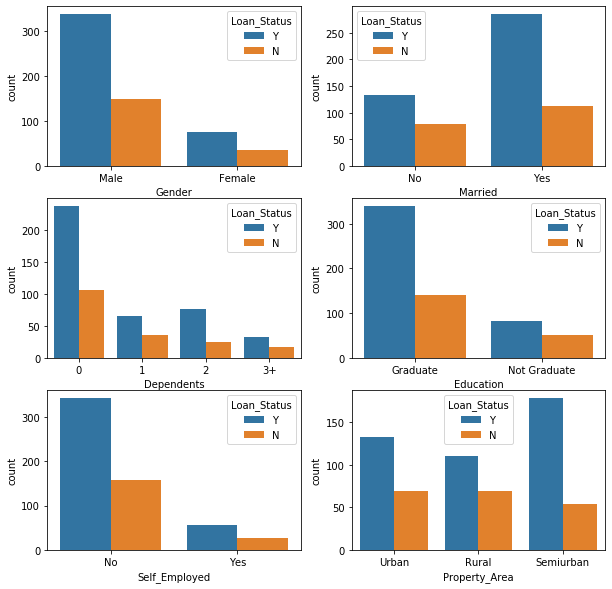

In [18]:
# count plot for categorical column on train data set
cat_columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
fig,axes=plt.subplots(3,2,figsize=(10,10))
for i,col in enumerate(cat_columns):
    row,colu=i//2,i%2
    sns.countplot(x=col,data=loan_train,hue='Loan_Status',ax=axes[row,colu])

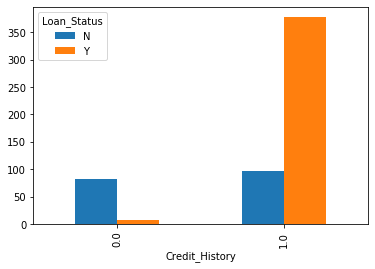

In [19]:
#approval count with respect to credit history.
pd.crosstab(loan_train['Credit_History'], loan_train['Loan_Status']).plot(kind='bar')

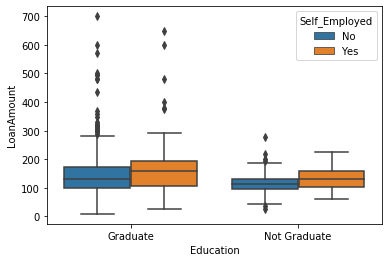

In [20]:
#comparing the loan amount applied interms of education for self employeed
sns.boxplot(x=loan_train['Education'], y=loan_train['LoanAmount'], hue=loan_train['Self_Employed'])

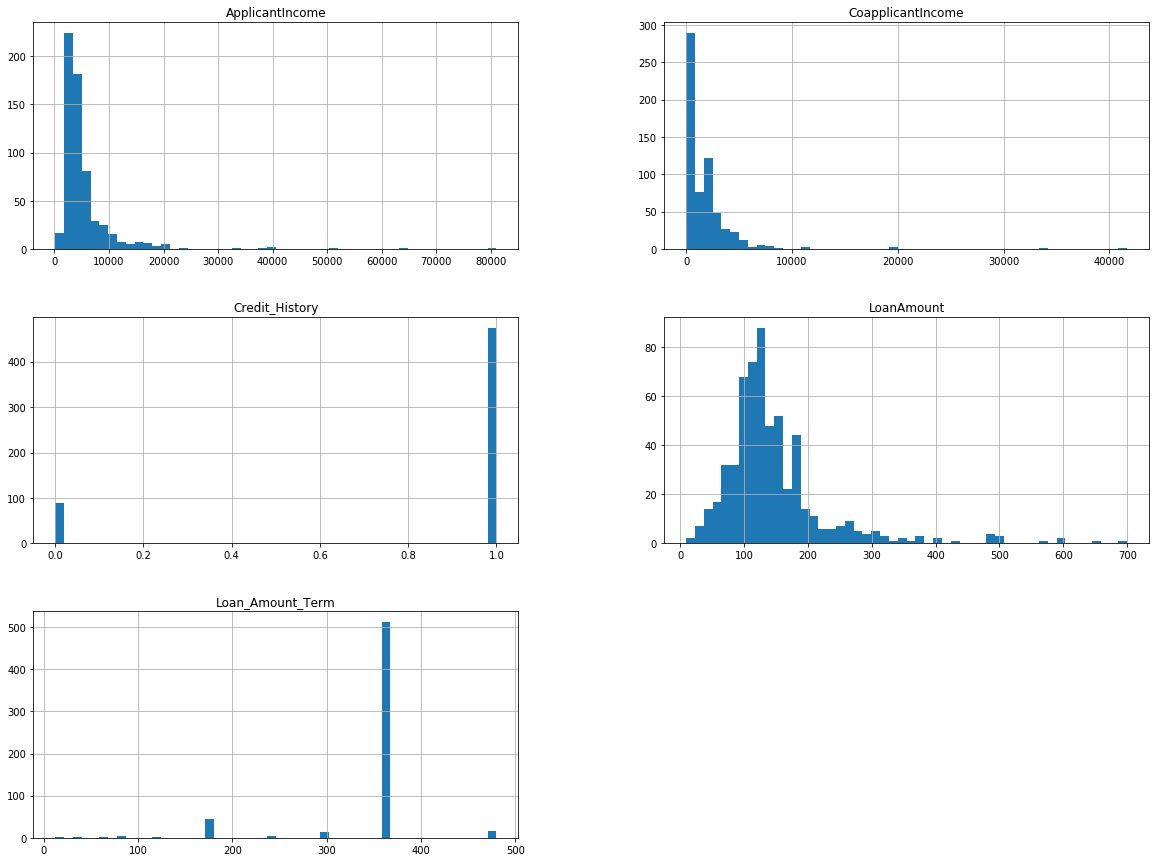

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
loan_train.hist(bins=50, figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.show()

# Treating Missing Values

In [22]:
#capturing all the features name has missing value
missingdata_df = loan_train.columns[loan_train.isnull().any()].tolist()


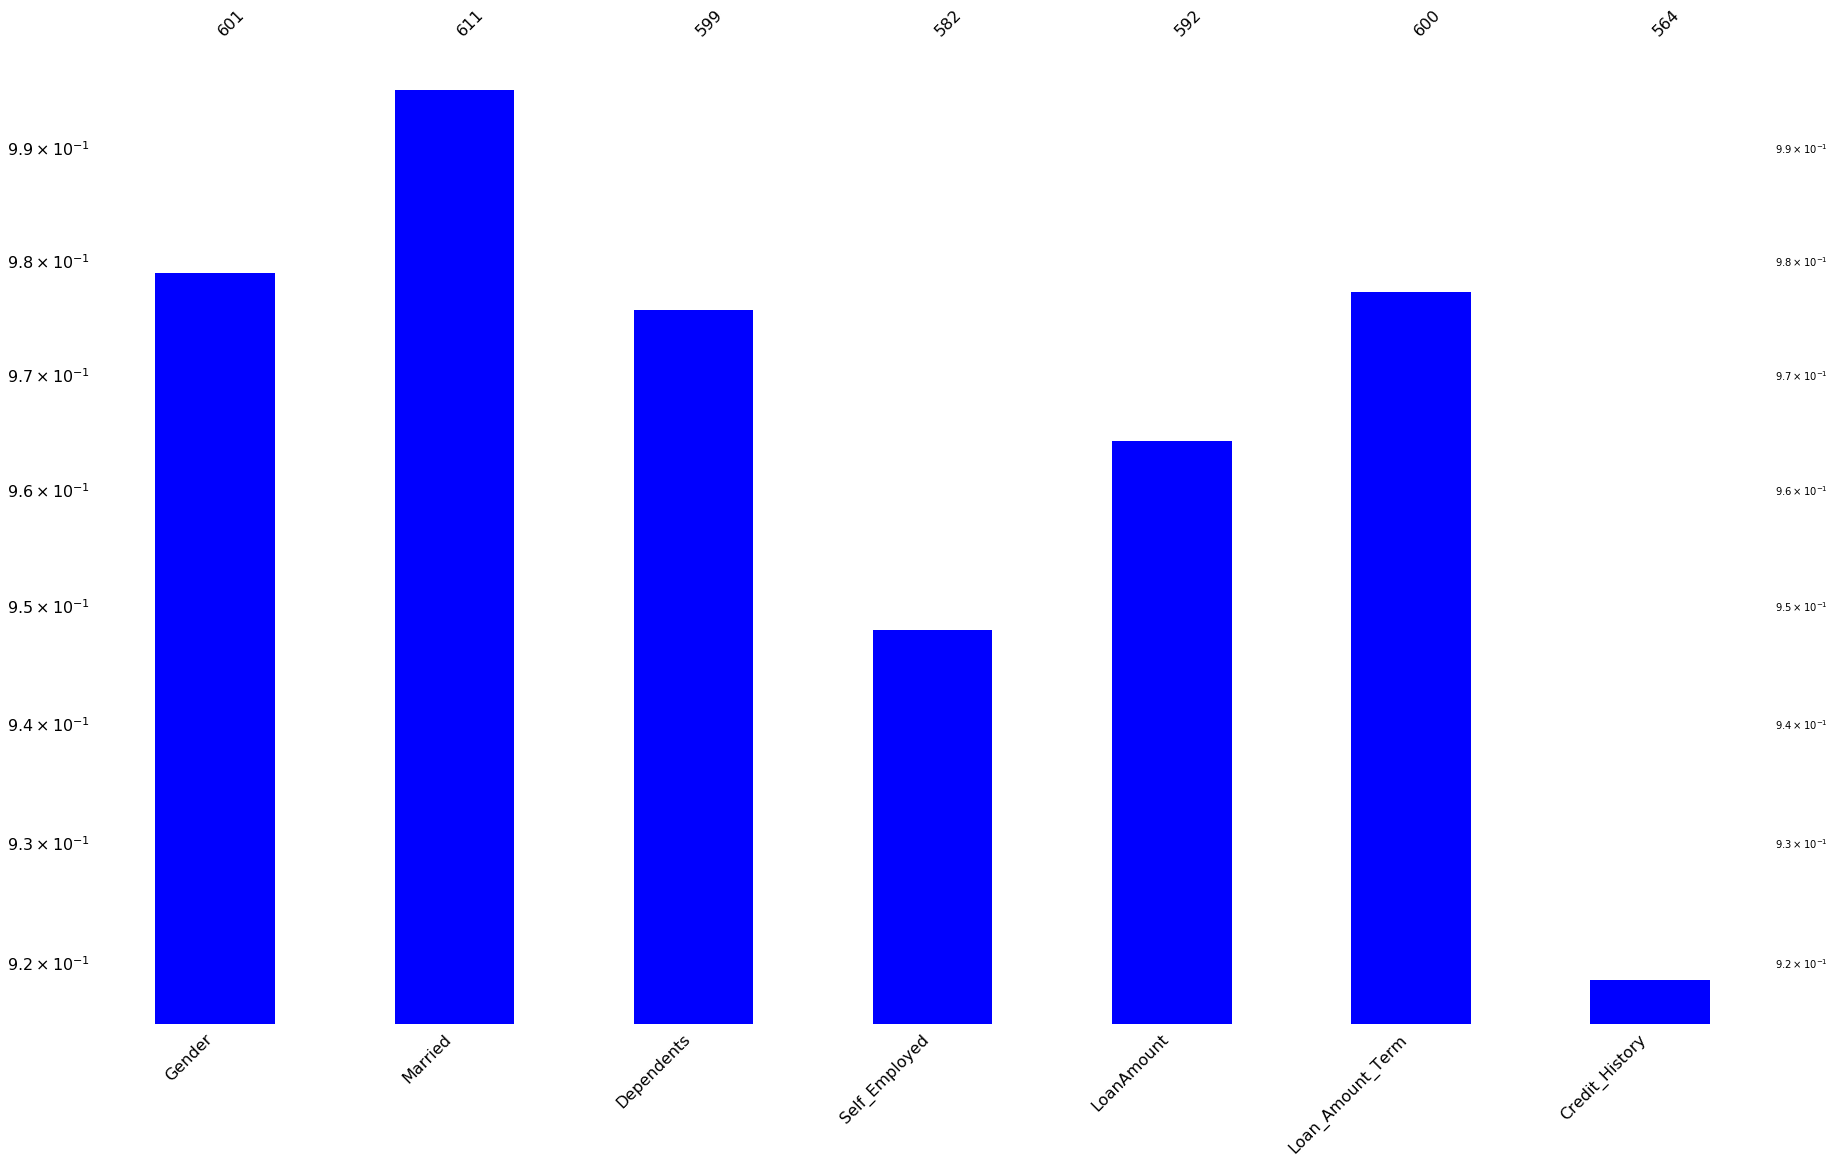

In [23]:
import missingno as msno
msno.bar(loan_train[missingdata_df], color="blue", log=True, figsize=(30,18))

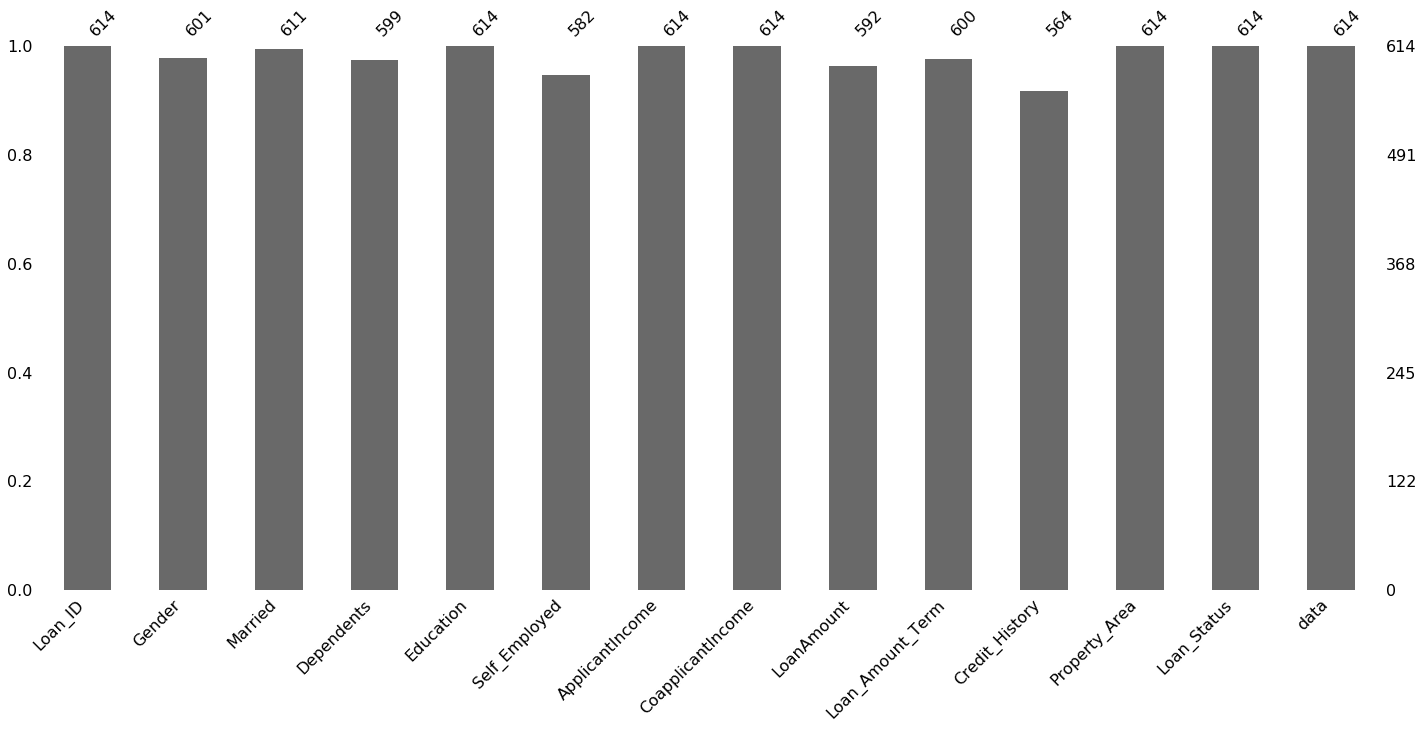

In [24]:
msno.bar(loan_train)

In [25]:
#missing data imputation using SimpleImputer
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(strategy="most_frequent")
#loan_all_final=pd.DataFrame(imp.fit_transform(loan_all.iloc[:,0:12]))
#loan_all_final

In [26]:
loan_all.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,data
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,train
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,train
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,train
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,train
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,train
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,train
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,train
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N,train
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y,train
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N,train


# imputing missing value


In [27]:
#imputing gander feature
#print("Shape of the Gender Feature:\n",loan_train['Gender'].shape)
#print("\nTotal unique value and its counts:\n\n",loan_train['Gender'].value_counts())
#print('\nTotal missing value count:',loan_train['Gender'].isna().sum())
loan_all['Gender'].fillna(loan_all['Gender'].mode()[0],inplace=True)
loan_all['Married'].fillna(loan_all['Married'].mode()[0],inplace=True)
loan_all['Dependents'].fillna(loan_all['Dependents'].mode()[0],inplace=True)
loan_all['Self_Employed'].fillna(loan_all['Self_Employed'].mode()[0],inplace=True)
loan_all['LoanAmount'].fillna(loan_all['LoanAmount'].median(),inplace=True)
loan_all['Loan_Amount_Term'].fillna(loan_all['Loan_Amount_Term'].mode()[0],inplace=True)
loan_all['Credit_History'].fillna(loan_all['Credit_History'].mode()[0],inplace=True)

# converting categorical to numerical

In [28]:
test=loan_all[loan_all['data']=='test'].drop(['data'],axis=1)
train=loan_all[loan_all['data']=='train'].drop('data',axis=1)
obj_var=list(loan_all.iloc[:,1:-1].select_dtypes(include=['object']))
obj_var

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [29]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
for i in obj_var:
    train[i]=label.fit_transform(train[i])
    test[i]=label.fit_transform(test[i])
    

In [30]:
test.shape

(367, 13)

In [31]:
print(train.shape)
train.head(5)

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,126.0,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


# Spliting data :

In [67]:
from sklearn.model_selection import train_test_split
X=train.drop(['Loan_ID','Loan_Status'],axis=1)
y=train['Loan_Status']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state =0)

In [68]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(491, 11)
(123, 11)
(491,)
(123,)


# Model 1: Decision Tree Classifier:

# Cheking Hyperparameters Optimization:

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score
from sklearn.model_selection import GridSearchCV
import time
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    start=time.time()
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15),'max_features': ['auto', 'sqrt', 'log2']}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    #return dtree_gscv.best_params_ , dtree_gscv.best_estimator_
    print('Best Parameters using grid search: \n', dtree_gscv.best_params_)
    print('Best Estimator using grid search: \n',dtree_gscv.best_estimator_)
    end = time.time()
    print('Time taken in grid search: {0: .2f}'.format(end - start))



dtree_grid_search(X_train,y_train,5)

Best Parameters using grid search: 
 {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2'}
Best Estimator using grid search: 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Time taken in grid search:  2.17


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Model building

In [58]:
giniDecisionTree = DecisionTreeClassifier(criterion='gini',random_state = 40,max_depth=5,min_samples_leaf =5)
giniDecisionTree.fit(X_train, y_train)
giniPred = giniDecisionTree.predict(X_test)
print('Train Accuracy Score: ',accuracy_score(y_train, giniDecisionTree.predict(X_train)))
print('Test Accuracy Score: ',accuracy_score(y_test, giniPred))
print('\nClassification Report')
print(classification_report(y_test, giniPred))

Train Accuracy Score:  0.8207739307535642
Test Accuracy Score:  0.8048780487804879

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.48      0.57        33
           1       0.83      0.92      0.87        90

    accuracy                           0.80       123
   macro avg       0.76      0.70      0.72       123
weighted avg       0.79      0.80      0.79       123



In [36]:
roc_auc_score(y_test, giniPred)

0.7010101010101011

# ROC CURVE for DT :

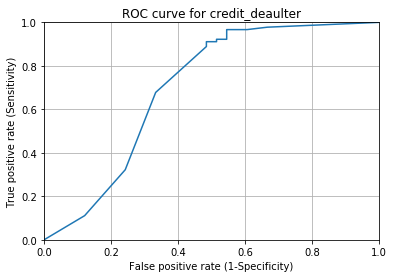

In [59]:
y_pred_prob=giniDecisionTree.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for credit_deaulter')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

In [38]:
#DT_entropy = DecisionTreeClassifier(criterion='entropy',random_state = 100,max_depth=3,min_samples_leaf = 35)
#DT_entropy.fit(X_train, y_train)
#pre_entropy = DT_entropy.predict(X_test)
#print('Test Accuracy Score: ',accuracy_score(y_test, pre_entropy))
#print('\nClassification Report')
#print(classification_report(y_test, pre_entropy))

# Feature Scaling:

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)

In [40]:
dtree_grid_search(X_train_scaler,y_train,5)

Best Parameters using grid search: 
 {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2'}
Best Estimator using grid search: 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Time taken in grid search:  0.89


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [60]:
gini_scaled_DT= DecisionTreeClassifier(criterion='gini',random_state = 100,max_depth=3,min_samples_leaf = 20)
gini_scaled_DT.fit(X_train_scaler, y_train)
giniPred = gini_scaled_DT.predict(X_test_scaler)
print('Train Accuracy Score: ',accuracy_score(y_train, gini_scaled_DT.predict(X_train_scaler)))
print('Test Accuracy Score: ',accuracy_score(y_test, giniPred))
print('\nClassification Report')
print(classification_report(y_test, giniPred))

Train Accuracy Score:  0.8044806517311609
Test Accuracy Score:  0.8292682926829268

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.42      0.57        33
           1       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123



# Model 2: Logistic Regression:

In [61]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [62]:
metrics.accuracy_score(y_test,y_pred)

0.8373983739837398

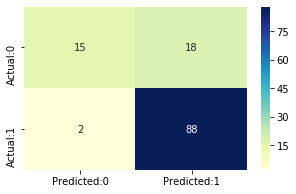

In [44]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,3))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [45]:
roc_auc_score(y_test, y_pred)

0.7161616161616162

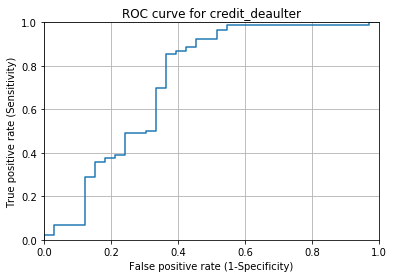

In [63]:
y_predLR_prob=lr.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_predLR_prob[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for credit_deaulter')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

# RandomForest classification.

# Cheking Hyperparameters Optimization:

In [47]:
from sklearn.ensemble import RandomForestClassifier
import time
import random
np.random.seed(42)
fit_rf = RandomForestClassifier(random_state=42)
start = time.time()
param_dist = {'max_depth':np.arange(3, 15),'bootstrap': [True, False],'max_features': ['auto', 'sqrt', 'log2', None],'criterion': ['gini', 'entropy']}
cv_rf = GridSearchCV(fit_rf, cv = 10,param_grid=param_dist, n_jobs = 3)
cv_rf.fit(X_train,y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto'}
Time taken in grid search:  24.91


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# model building:

In [64]:
model_rf = RandomForestClassifier(criterion='entropy',random_state = 42,max_depth=6,max_features = 'auto')
model_rf.fit(X_train, y_train)
rf_Pred = model_rf.predict(X_test)
print('Train Accuracy Score: ',accuracy_score(y_train, model_rf.predict(X_train)))
print('Test Accuracy Score: ',accuracy_score(y_test, rf_Pred))
print('\nClassification Report')
print(classification_report(y_test, rf_Pred))
print("\n roc_auc score : \n",roc_auc_score(y_test, rf_Pred))

Train Accuracy Score:  0.8289205702647657
Test Accuracy Score:  0.8292682926829268

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.42      0.57        33
           1       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123


 roc_auc score : 
 0.7010101010101011


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# ROC Curve for RF:

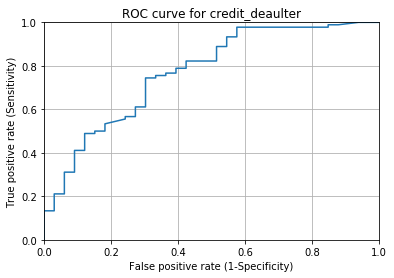

In [65]:
rf_y_pred_prob=model_rf.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, rf_y_pred_prob[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for credit_deaulter')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

# Finding Important Features

In [73]:

feature_imp = pd.Series(model_rf.feature_importances_*100,index=X.columns).sort_values(ascending=False)
feature_imp

Credit_History       50.539173
ApplicantIncome      18.132506
LoanAmount           10.565533
CoapplicantIncome     7.213417
Loan_Amount_Term      4.634951
Dependents            3.122358
Property_Area         1.609332
Gender                1.259716
Education             1.229343
Married               1.032646
Self_Employed         0.661025
dtype: float64

# RandomForest classification with feature selection

In [74]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [80]:
X1=train[['Credit_History','ApplicantIncome','LoanAmount','CoapplicantIncome','Loan_Amount_Term','Dependents']]

y1=train['Loan_Status']
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.2,random_state =0)

In [83]:
X1_train_scaler = scaler.fit_transform(X1_train)
X1_test_scaler = scaler.fit_transform(X1_test)

In [84]:
from sklearn.ensemble import RandomForestClassifier
import time
import random
np.random.seed(42)
fit_rf = RandomForestClassifier(random_state=42)
start = time.time()
param_dist = {'max_depth':np.arange(3, 15),'bootstrap': [True, False],'max_features': ['auto', 'sqrt', 'log2', None],'criterion': ['gini', 'entropy']}
cv_rf = GridSearchCV(fit_rf, cv = 10,param_grid=param_dist, n_jobs = 3)
cv_rf.fit(X1_train_scaler,y1_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto'}
Time taken in grid search:  20.70


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [85]:
model_rf1 = RandomForestClassifier(criterion='entropy',random_state = 42,max_depth=9,max_features = 'auto')
model_rf1.fit(X1_train_scaler, y1_train)
rf1_Pred = model_rf1.predict(X1_test_scaler)
print('Train Accuracy Score: ',accuracy_score(y1_train, model_rf1.predict(X1_train_scaler)))
print('Test Accuracy Score: ',accuracy_score(y1_test, rf1_Pred))
print('\nClassification Report')
print(classification_report(y1_test, rf1_Pred))
print("\n roc_auc score : \n",roc_auc_score(y1_test, rf1_Pred))

Train Accuracy Score:  0.8655804480651731
Test Accuracy Score:  0.6910569105691057

Classification Report
              precision    recall  f1-score   support

           0       0.44      0.52      0.47        33
           1       0.81      0.76      0.78        90

    accuracy                           0.69       123
   macro avg       0.62      0.64      0.63       123
weighted avg       0.71      0.69      0.70       123


 roc_auc score : 
 0.6353535353535353


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
